# Problem Statement

An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses. 

 

The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is around 30%. 

 

Now, although X Education gets a lot of leads, its lead conversion rate is very poor. For example, if, say, they acquire 100 leads in a day, only about 30 of them are converted. To make this process more efficient, the company wishes to identify the most potential leads, also known as ‘Hot Leads’. If they successfully identify this set of leads, the lead conversion rate should go up as the sales team will now be focusing more on communicating with the potential leads rather than making calls to everyone. A typical lead conversion process can be represented using the following funnel:

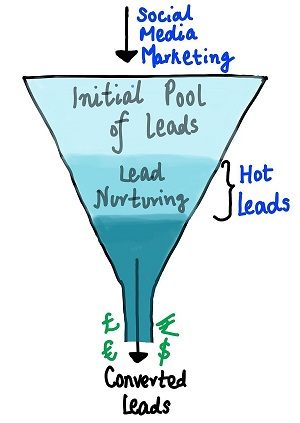

As you can see, there are a lot of leads generated in the initial stage (top) but only a few of them come out as paying customers from the bottom. In the middle stage, you need to nurture the potential leads well (i.e. educating the leads about the product, constantly communicating etc. ) in order to get a higher lead conversion.

 

X Education has appointed you to help them select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires you to build a model wherein you need to assign a lead score to each of the leads such that the customers with a higher lead score have a higher conversion chance and the customers with a lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

### Data

You have been provided with a leads dataset from the past with around 9000 data points. This dataset consists of various attributes such as Lead Source, Total Time Spent on Website, Total Visits, Last Activity, etc. which may or may not be useful in ultimately deciding whether a lead will be converted or not. The target variable, in this case, is the column ‘Converted’ which tells whether a past lead was converted or not wherein 1 means it was converted and 0 means it wasn’t converted. You can learn more about the dataset from the data dictionary provided in the zip folder at the end of the page. Another thing that you also need to check out are the levels present in the categorical variables. Many of the categorical variables have a level called 'Select' which needs to be handled because it is as good as a null value (think why?).

## Goals of the case study

There are quite a few goals for this case study:

Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.
There are some more problems presented by the company which your model should be able to adjust to if the company's requirement changes in the future so you will need to handle these as well. These problems are provided in a separate doc file. Please fill it based on the logistic regression model you got in the first step. Also, make sure you include this in your final PPT where you'll make recommendations.

# Solution

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

## Common Functions to be used in the solutions

1. **get_dt_graph:** This will create and plot graphs for the solutions
2. **evaluate_model:** This will evaluate the models against for Accuracy and Confusion Matrix
3. **draw_roc:** This function generates and displays the Receiver Operating Characteristic (ROC) curve for a given set of actual labels and predicted probabilities. It calculates the false positive rate (FPR) and true positive rate (TPR) at various threshold settings, computes the Area Under the ROC Curve (AUC), and plots the ROC curve along with the AUC score. The function includes a diagonal reference line representing random guessing. The plot is displayed with labeled axes and a legend indicating the AUC score.

In [11]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [12]:
def get_dt_graph(dt_classifier, columns, class_names):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=columns, 
                    class_names=class_names)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [13]:
def evaluate_model(dt_classifier, y_train, X_train, y_test, X_test):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

In [15]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

## 1. Reading & understanding the dataset

In [ ]:
leads = pd.read_csv('Leads.csv')
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [ ]:
leads.shape

(9240, 37)

In [ ]:
leads.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [ ]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

##  2. Data Cleaning 
### -Formating the data as required to process them.
1. Removing the rownumbers.
2. Treating null values.
3. Dropping unnecessary columns for analysis. 


Removing Index columns
Check if any duplicate values are present in the index columns here. If present It has to be treated, else they can be dropped as it is not relavent for data analysis.
The first two columns 'Prospect ID' and 'Lead Number' are the two index columns in this dataset.

In [ ]:
sum(leads.duplicated(subset = 'Prospect ID')) == 0
sum(leads.duplicated(subset = 'Lead Number')) == 0

True

Since there are no duplicate values, we remove these columns from the dataframe.

In [ ]:
#dropping indexes
leads.drop(['Prospect ID', 'Lead Number'], axis=1, inplace = True)

In [ ]:
# Replacing the select variable with NaN
leads = leads.replace('Select', np.nan)

In [ ]:
leads.isnull().sum()

Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   3380
How did you hear about X Education               7250
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article                                   0
X Education Forums                                  0
Newspaper                   

In [ ]:
leads.index

RangeIndex(start=0, stop=9240, step=1)

### Handling Null Values

In [ ]:
#check the percentage of nulls
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

In [ ]:
# drop columns with 40% or more null values.
colum=leads.columns

for i in colum:
    if((100*(leads[i].isnull().sum()/len(leads.index))) >= 40):
        leads.drop(i, axis = 1, inplace = True)

In [ ]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [ ]:
# Analysing the value_count of City column as it has the highest amount of nulls, after dropping columns having 40% or above null values.
leads['City'].value_counts(dropna=False)

City
NaN                            3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: count, dtype: int64

Since most of the values are generated from the city 'Mumbai' we replace the null values also with 'Mumbai'.

In [ ]:
leads['City'] = leads['City'].replace(np.nan,'Mumbai')

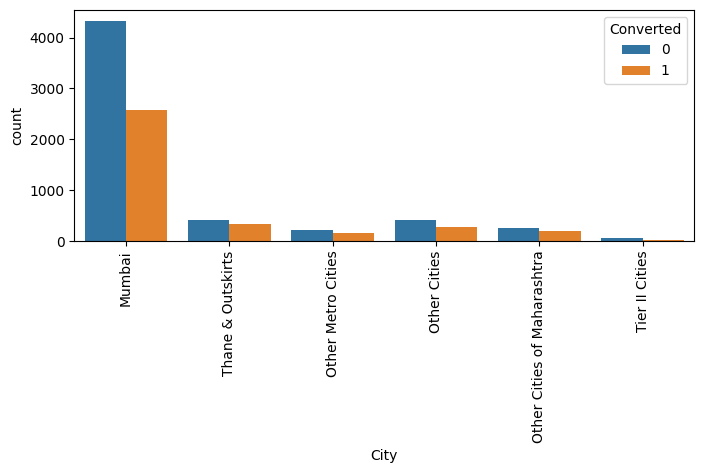

In [ ]:
plt.figure(figsize=(8,3))
spr=sns.countplot(x=leads.City, hue=leads.Converted)
spr.set_xticklabels(spr.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
#Treating the next highest null Values 'Specialization'
leads['Specialization'].value_counts(dropna=False)

Specialization
NaN                                  3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: count, dtype: int64

In [ ]:
#Since NaN has max values, we replace it as a category to consider it while calculating conversion rate.
leads['Specialization'] = leads['Specialization'].replace(np.nan, 'None')

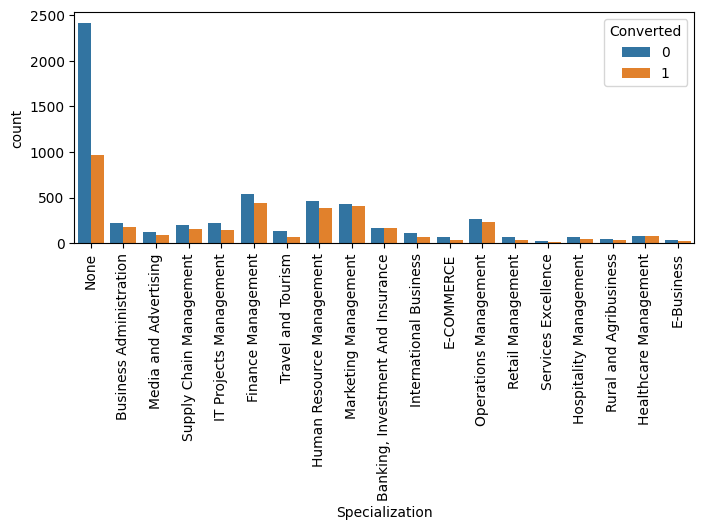

In [ ]:

plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads.Specialization, hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

A few of these categories are actually sub-caterogy of management stream, hence replacing all of it by 'Management_Specialization'.

In [ ]:
#Management_Specialization
leads['Specialization'] = leads['Specialization'].replace(['Finance Management','Human Resource Management',
                                                           'Marketing Management','Operations Management',
                                                           'IT Projects Management','Supply Chain Management',
                                                    'Healthcare Management','Hospitality Management',
                                                           'Retail Management'] ,'Management_Specializations')  

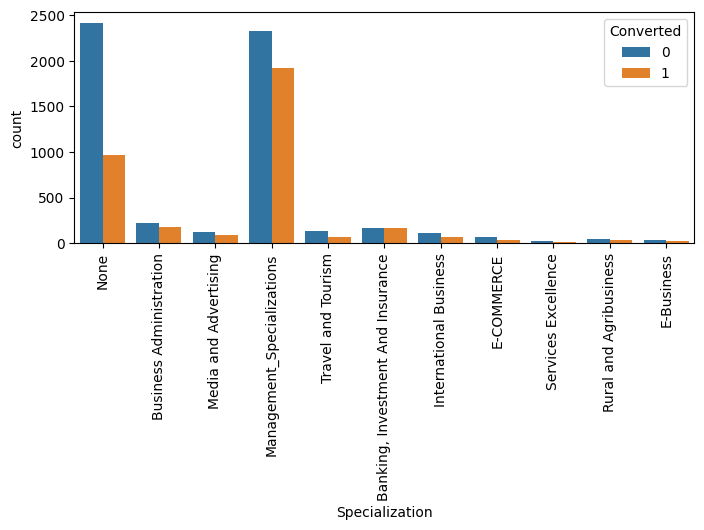

In [ ]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads.Specialization, hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                    0.00
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [ ]:
leads['Tags'].value_counts(dropna=False)

Tags
NaN                                                  3353
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch 

In [ ]:
leads['Tags'] = leads['Tags'].replace(np.nan,'None')

In [ ]:
leads['Tags'] = leads['Tags'].replace(['In confusion whether part time or DLP', 'in touch with EINS','Diploma holder (Not Eligible)',
                                     'Approached upfront','Graduation in progress','number not provided', 'opp hangup','Still Thinking',
                                    'Lost to Others','Shall take in the next coming month','Lateral student','Interested in Next batch',
                                    'Recognition issue (DEC approval)','Want to take admission but has financial problems',
                                    'University not recognized','switched off','Already a student','Not doing further education','invalid number',
                                    'wrong number given','Interested  in full time MBA'], 'Other_Tags')


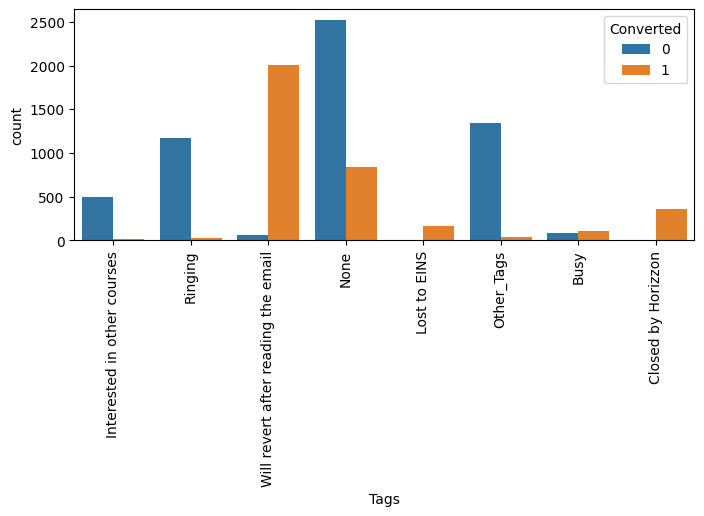

In [ ]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['Tags'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
#next highest null values
leads['What is your current occupation'].value_counts(dropna=False)

What is your current occupation
Unemployed              5600
NaN                     2690
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: count, dtype: int64

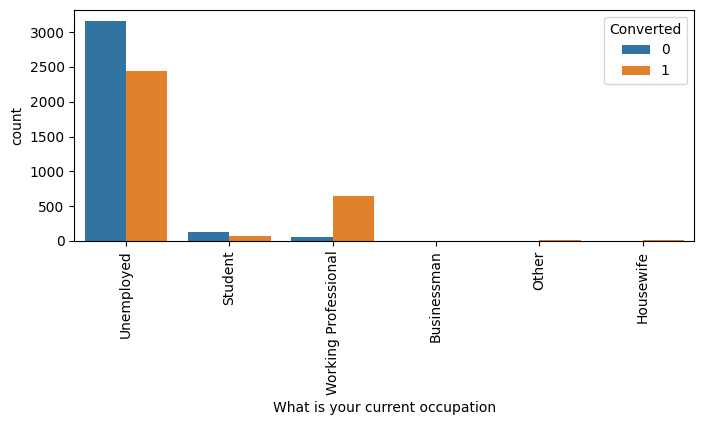

In [ ]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['What is your current occupation'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
leads['What is your current occupation'] = leads['What is your current occupation'].replace(np.nan, 'Unemployed')

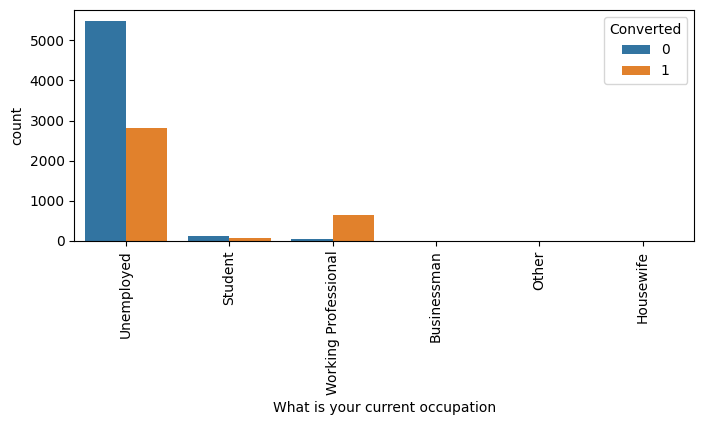

In [ ]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['What is your current occupation'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
leads['What matters most to you in choosing a course'].value_counts(dropna=False)

What matters most to you in choosing a course
Better Career Prospects      6528
NaN                          2709
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

In [ ]:
leads['What matters most to you in choosing a course'] = leads['What matters most to you in choosing a course'].replace(np.nan,'Better Career Prospects')

In [ ]:
leads['What matters most to you in choosing a course'].value_counts(dropna=False)

What matters most to you in choosing a course
Better Career Prospects      9237
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

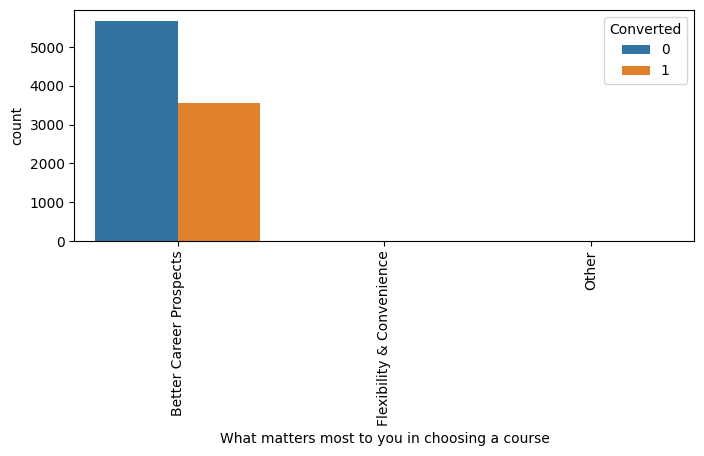

In [ ]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['What matters most to you in choosing a course'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
leads['What matters most to you in choosing a course'].value_counts(dropna=False)

What matters most to you in choosing a course
Better Career Prospects      9237
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

In [ ]:
cols_to_drop=['What matters most to you in choosing a course']

Checking if all nulls have been treated appropriately

In [ ]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                    0.00
What is your current occupation                   0.00
What matters most to you in choosing a course     0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [ ]:
leads['Country'].value_counts(dropna=False)

Country
India                   6492
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Canada                     4
Nigeria                    4
Germany                    4
Sweden                     3
Philippines                2
Uganda                     2
Italy                      2
Bangladesh                 2
Netherlands                2
Asia/Pacific Region        2
China                      2
Belgium                    2
Ghana                      2
Kenya                      1
Sri Lanka                  1
Tanzania                   1
Malaysia                   1
Liberia                    1
Switze

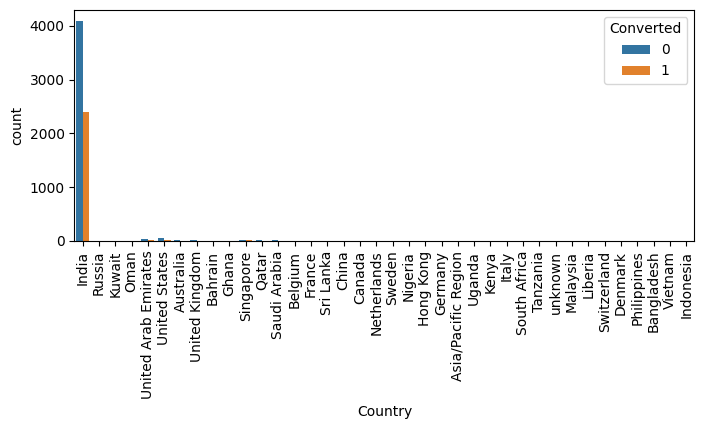

In [ ]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads.Country, hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
cols_to_drop.append('Country')
cols_to_drop

['What matters most to you in choosing a course',
 'Country',
 'Do Not Call',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'I agree to pay the amount through cheque',
 'Country']

In [ ]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                    0.00
What is your current occupation                  29.11
What matters most to you in choosing a course     0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [ ]:
leads['Lead Source'].value_counts(dropna=False)

Lead Source
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: count, dtype: int64

In [ ]:
leads['Lead Source'] = leads['Lead Source'].replace(np.nan,'Others')
leads['Lead Source'] = leads['Lead Source'].replace('google','Google')
leads['Lead Source'] = leads['Lead Source'].replace('Facebook','Social Media')
leads['Lead Source'] = leads['Lead Source'].replace(['bing','Click2call','Press_Release',
                                                     'youtubechannel','welearnblog_Home',
                                                     'WeLearn','blog','Pay per Click Ads',
                                                    'testone','NC_EDM'] ,'Others')

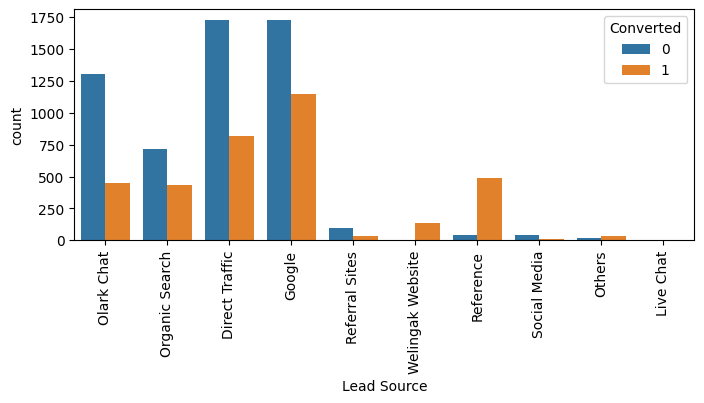

In [ ]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['Lead Source'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
leads['Last Activity'].value_counts(dropna=False)

Last Activity
Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
NaN                              103
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: count, dtype: int64

In [ ]:
leads['Last Activity'] = leads['Last Activity'].replace(np.nan,'Others')
leads['Last Activity'] = leads['Last Activity'].replace(['Unreachable','Unsubscribed',
                                                        'Had a Phone Conversation', 
                                                        'Approached upfront',
                                                        'View in browser link Clicked',       
                                                        'Email Marked Spam',                  
                                                        'Email Received','Resubscribed to emails',
                                                         'Visited Booth in Tradeshow'],'Others')

In [ ]:
leads['Last Activity'].value_counts(dropna=False)

Last Activity
Email Opened                 3437
SMS Sent                     2745
Olark Chat Conversation       973
Page Visited on Website       640
Converted to Lead             428
Email Bounced                 326
Others                        308
Email Link Clicked            267
Form Submitted on Website     116
Name: count, dtype: int64

In [ ]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                    0.00
What is your current occupation                  29.11
What matters most to you in choosing a course     0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [ ]:
leads = leads.dropna()

In [ ]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                                0.0
X Education Forums                               0.0
Newspaper                                        0.0
Digital Advertisement                         

All the values are now non-zero. Now that all the nulls are treated, we compare the variables.

In [ ]:
leads['Lead Origin'].value_counts(dropna=False)

Lead Origin
Landing Page Submission    4850
API                        1902
Lead Add Form                27
Name: count, dtype: int64

# 3. Exploratory Data Analysis

Plotting a graph of count plot between converted and the count of Leads Originated.

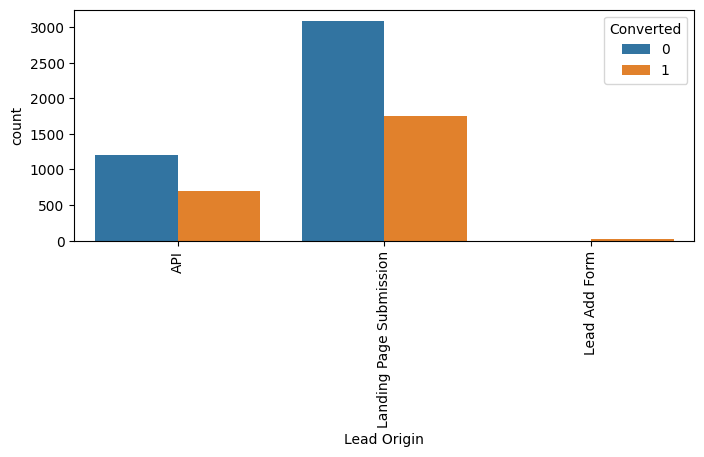

In [ ]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['Lead Origin'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

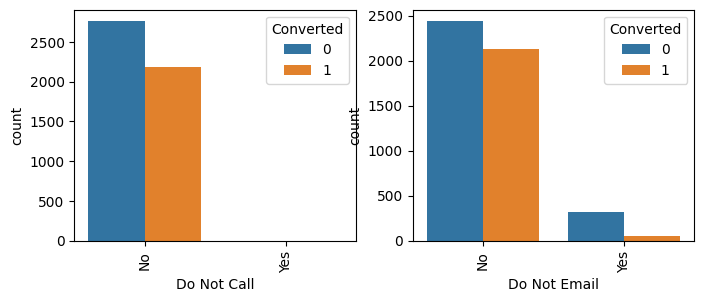

In [ ]:
#Plotting Do not call and Do not Email variables against the converted varilable.
plt.figure(figsize=(8,3))

ax1=plt.subplot(1, 2, 1)
ax1=sns.countplot(x=leads['Do Not Call'], hue=leads.Converted)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)

ax2=plt.subplot(1, 2, 2)
ax2=sns.countplot(x=leads['Do Not Email'], hue=leads.Converted)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
# Checking actual count of the variable value
leads['Do Not Call'].value_counts(dropna=False)

Do Not Call
No     6778
Yes       1
Name: count, dtype: int64

In [ ]:
# Checking actual count of the variable value
leads['Do Not Email'].value_counts(dropna=False)

Do Not Email
No     6186
Yes     593
Name: count, dtype: int64

In [ ]:
# Since the variable 'Do not Call' is highly biased, we plan to drop the variable
cols_to_drop.append('Do Not Call')
cols_to_drop

['What matters most to you in choosing a course', 'Country', 'Do Not Call']

In [ ]:
leads.Search.value_counts(dropna=False)

Search
No     6765
Yes      14
Name: count, dtype: int64

In [ ]:
leads['Newspaper Article'].value_counts(dropna=False)

Newspaper Article
No     4943
Yes       1
Name: count, dtype: int64

In [ ]:
leads['X Education Forums'].value_counts(dropna=False)

X Education Forums
No    4944
Name: count, dtype: int64

In [ ]:
leads['Newspaper'].value_counts(dropna=False)

Newspaper
No     4943
Yes       1
Name: count, dtype: int64

In [ ]:
leads['Digital Advertisement'].value_counts(dropna=False)

Digital Advertisement
No     4941
Yes       3
Name: count, dtype: int64

In [ ]:
leads['Through Recommendations'].value_counts(dropna=False)

Through Recommendations
No     4938
Yes       6
Name: count, dtype: int64

In [ ]:
leads['Receive More Updates About Our Courses'].value_counts(dropna=False)

Receive More Updates About Our Courses
No    4944
Name: count, dtype: int64

In [ ]:
leads['Update me on Supply Chain Content'].value_counts(dropna=False)

Update me on Supply Chain Content
No    4944
Name: count, dtype: int64

In [ ]:
leads['Get updates on DM Content'].value_counts(dropna=False)

Get updates on DM Content
No    4944
Name: count, dtype: int64

In [ ]:
leads['I agree to pay the amount through cheque'].value_counts(dropna=False)

I agree to pay the amount through cheque
No    4944
Name: count, dtype: int64

In [ ]:
leads['A free copy of Mastering The Interview'].value_counts(dropna=False)

A free copy of Mastering The Interview
No     2789
Yes    2155
Name: count, dtype: int64

In [ ]:
cols_to_drop.extend(['Search','Magazine','Newspaper Article','X Education Forums','Newspaper',
                 'Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses',
                 'Update me on Supply Chain Content',
                 'Get updates on DM Content','I agree to pay the amount through cheque'])

In [ ]:
leads['Last Notable Activity'].value_counts()

Last Notable Activity
Email Opened                    1617
Modified                        1503
SMS Sent                        1406
Page Visited on Website          194
Email Link Clicked                77
Olark Chat Conversation           45
Email Bounced                     40
Unsubscribed                      27
Unreachable                       18
Had a Phone Conversation          13
Approached upfront                 1
View in browser link Clicked       1
Email Received                     1
Email Marked Spam                  1
Name: count, dtype: int64

In [ ]:
leads['Last Notable Activity'] = leads['Last Notable Activity'].replace(['Had a Phone Conversation',
                                                                       'Email Marked Spam',
                                                                         'Unreachable',
                                                                         'Unsubscribed',
                                                                         'Email Bounced',                                                                    
                                                                       'Resubscribed to emails',
                                                                       'View in browser link Clicked',
                                                                       'Approached upfront', 
                                                                       'Form Submitted on Website', 
                                                                       'Email Received'],'Other_Notable_activity')


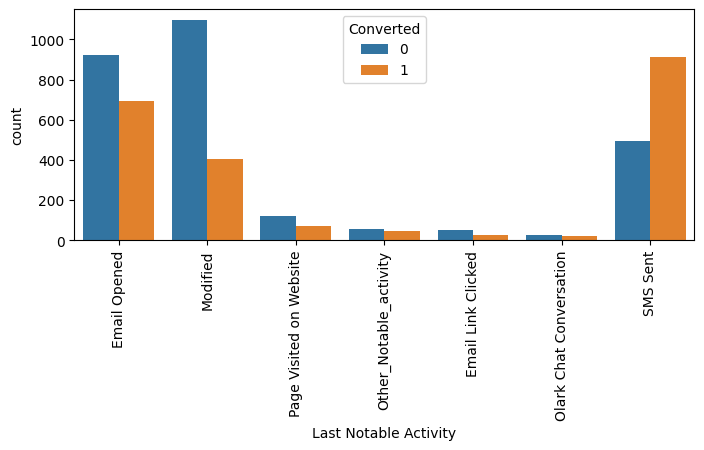

In [ ]:

plt.figure(figsize = (8,3))
ax1=sns.countplot(x = "Last Notable Activity", hue = "Converted", data = leads)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
leads['Last Notable Activity'].value_counts()

Last Notable Activity
Modified                   2331
Email Opened               2212
SMS Sent                   1643
Page Visited on Website     286
Other_Notable_activity      133
Email Link Clicked          106
Olark Chat Conversation      68
Name: count, dtype: int64

In [ ]:
cols_to_drop

['What matters most to you in choosing a course',
 'Country',
 'Do Not Call',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'I agree to pay the amount through cheque']

In [ ]:
leads = leads.drop(cols_to_drop,axis = 1)
leads.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6779 entries, 1 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             6779 non-null   object 
 1   Lead Source                             6779 non-null   object 
 2   Do Not Email                            6779 non-null   object 
 3   Converted                               6779 non-null   int64  
 4   TotalVisits                             6779 non-null   float64
 5   Total Time Spent on Website             6779 non-null   int64  
 6   Page Views Per Visit                    6779 non-null   float64
 7   Last Activity                           6779 non-null   object 
 8   Specialization                          6779 non-null   object 
 9   What is your current occupation         6779 non-null   object 
 10  Tags                                    6779 non-null   object 
 

In [ ]:
Converted = (sum(leads['Converted'])/len(leads['Converted'].index))*100
Converted

36.65732408909869

In [ ]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6779 entries, 1 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             6779 non-null   object 
 1   Lead Source                             6779 non-null   object 
 2   Do Not Email                            6779 non-null   object 
 3   Converted                               6779 non-null   int64  
 4   TotalVisits                             6779 non-null   float64
 5   Total Time Spent on Website             6779 non-null   int64  
 6   Page Views Per Visit                    6779 non-null   float64
 7   Last Activity                           6779 non-null   object 
 8   Specialization                          6779 non-null   object 
 9   What is your current occupation         6779 non-null   object 
 10  Tags                                    6779 non-null   object 
 

### Now that all data is set, we find the correlation matrix of numeric variables.

In [ ]:
numcol= leads.select_dtypes(include=['int64','float64']).columns
corl=leads[numcol]

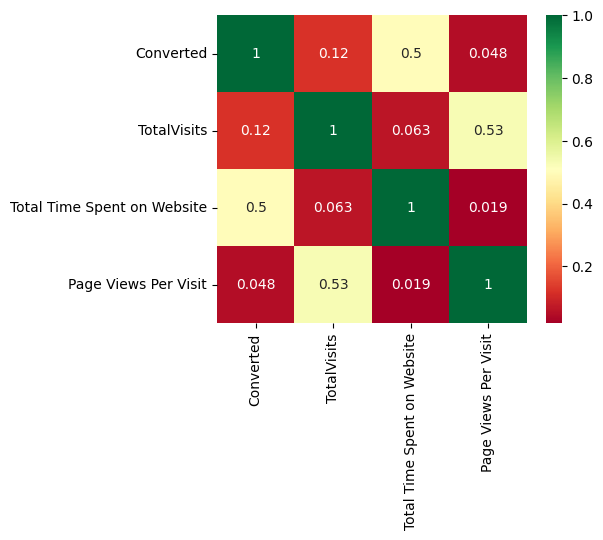

In [ ]:
plt.figure(figsize=(5,4))

# heatmap
sns.heatmap(data=corl.corr(), cmap="RdYlGn", annot=True)
plt.show()

### Analysis-
1. Converted has highest corelation with the total time spent on website, which means more time spent on the website will be a potential lead worthy of conversion.
2. Also, page views per visit has the least corelation with converted variable, which means the conversion rate cannot be predicted with the number of pages viewed on a visit.


### Handling Outliers

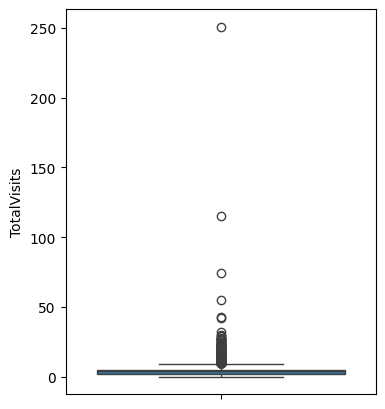

In [ ]:
plt.figure(figsize=(4,5))
sns.boxplot(y=leads['TotalVisits'])
plt.show()

In [ ]:
#bucketing the total Visits values
leads['TotalVisits'].describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

count    6779.000000
mean        4.553917
std         5.138148
min         0.000000
5%          1.000000
25%         2.000000
50%         4.000000
75%         5.000000
90%         8.000000
95%        11.000000
99%        18.220000
max       251.000000
Name: TotalVisits, dtype: float64

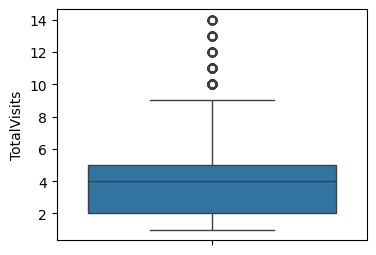

In [ ]:
# working on the interquartile range of qtr3 and qtr1

plt.figure(figsize=(4,3))
Q3 = leads.TotalVisits.quantile(0.99)
leads = leads[(leads.TotalVisits <= Q3)]
Q1 = leads.TotalVisits.quantile(0.01)
leads = leads[(leads.TotalVisits >= Q1)]
sns.boxplot(y=leads['TotalVisits'])
plt.show()

In [ ]:
leads.shape

(6706, 14)

In [ ]:
#bucketing the 'Total Time Spent on Website' values
leads['Total Time Spent on Website'].describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

count    6706.000000
mean      631.736206
std       541.763382
min         0.000000
5%         33.000000
25%       171.000000
50%       397.000000
75%      1104.000000
90%      1451.500000
95%      1606.000000
99%      1862.950000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

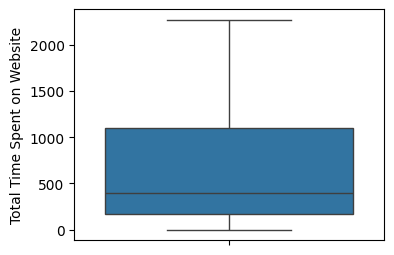

In [ ]:
plt.figure(figsize=(4,3))
sns.boxplot(y=leads['Total Time Spent on Website'])
plt.show()

In [ ]:
leads['Page Views Per Visit'].describe()


count    6640.000000
mean        3.085809
std         1.773223
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        14.000000
Name: Page Views Per Visit, dtype: float64

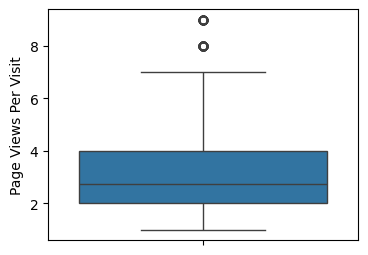

In [ ]:
plt.figure(figsize=(4,3))
sns.boxplot(y=leads['Page Views Per Visit'])
plt.show()

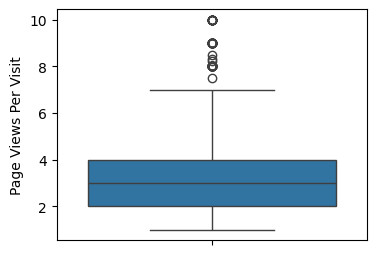

In [ ]:
# working on the interquartile range of qtr3 and qtr1

plt.figure(figsize=(4,3))
Q3 = leads['Page Views Per Visit'].quantile(0.99)
leads = leads[leads['Page Views Per Visit'] <= Q3]
Q1 = leads['Page Views Per Visit'].quantile(0.01)
leads = leads[leads['Page Views Per Visit'] >= Q1]
sns.boxplot(y=leads['Page Views Per Visit'])
plt.show()

In [ ]:
leads.shape

(6536, 14)

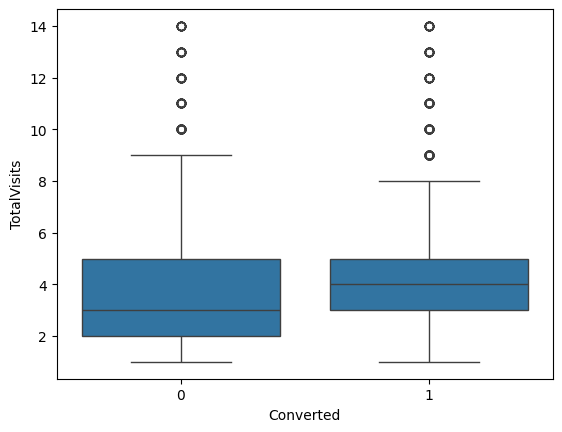

In [ ]:
# Plotting a boxplot for converted and total visits.
sns.boxplot(y = 'TotalVisits', x = 'Converted', data = leads)
plt.show()

### Analysis-
1. The not converted vs converted mean are around the same region, whereas the amount of conversion is fairly smaller.
The upper quartile is almost the same for both converted and not converted categories.

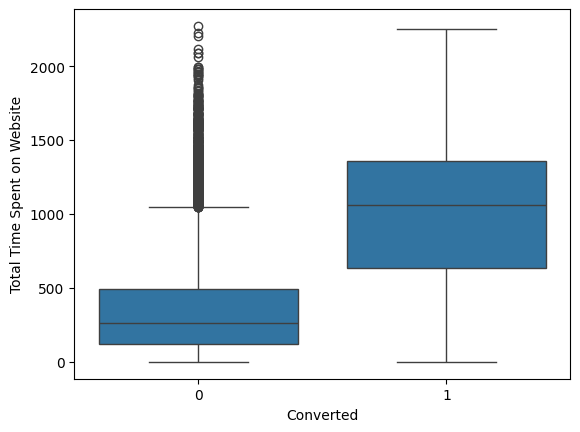

In [ ]:
sns.boxplot(x=leads.Converted, y=leads['Total Time Spent on Website'])
plt.show()

### analysis-
As seen earlier, higher the time spent on the webpage, higher is the conversion rate of the lead.
Thus those custmers who spend more time on the web page should be considered high potential leads.

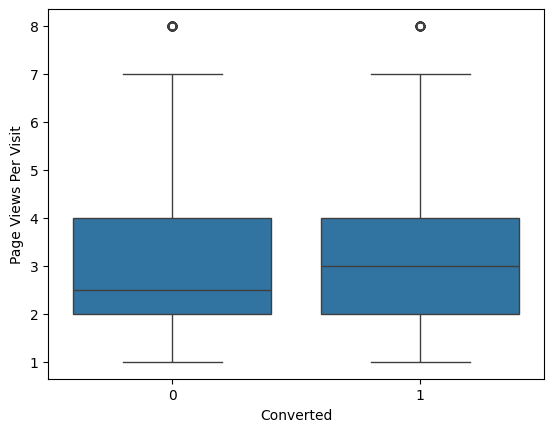

In [ ]:
sns.boxplot(x=leads.Converted,y=leads['Page Views Per Visit'])
plt.show()

### Analysis-
1. The median of the average page views for converted is higher than for not converted.
2. If a lead views more number of pages as compared to the average number of page visits, they can be considered as a potential leads.

In [ ]:
round(100*(leads.isnull().sum()/len(leads.index)),2)

Lead Origin                               0.0
Lead Source                               0.0
Do Not Email                              0.0
Converted                                 0.0
TotalVisits                               0.0
Total Time Spent on Website               0.0
Page Views Per Visit                      0.0
Last Activity                             0.0
Specialization                            0.0
What is your current occupation           0.0
Tags                                      0.0
City                                      0.0
A free copy of Mastering The Interview    0.0
Last Notable Activity                     0.0
dtype: float64

In [ ]:
catcol= leads.select_dtypes(include=['object']).columns
catcol

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity',
       'Specialization', 'What is your current occupation', 'Tags', 'City',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

## Define the target variable

## Create dummy variables for the independent variables

## Training - Test Data Split

## Fine tuning and Analysis